# RNA-ATAC: scButterfly-C

The following tutorial demonstrate how to use scButterfly-C variant with data augmentation using MultiVI cluster labels. 

scButterfly-C with MultiVI cluster labels data augmentation will generate synthetic paired data by randomly paired scRNA-seq and scATAC-seq of different cells with the same cluster labels. [Leiden](https://www.nature.com/articles/s41598-019-41695-z/) is used on the embedding space of [MultiVI](https://www.nature.com/articles/s41592-023-01909-9), which is a single-cell multi-omics data joint analysis method in Python packages [scvi-tools](https://docs.scvi-tools.org/en/stable/). The supplement of these generated data will provide scButterfly a better performance of translation, but take more time for training.

<div class="alert note">
<p>

**Note**

Most of this tutorial is same as [scButterfly-B](RNA_ATAC_paired_scButterfly-B.ipynb) with more details of data pre-processing, model constructing, model training and evaluating. It's prefered to see that first, because it has no different in parts mentioned above, but have more useful notes.


</p>
</div>

In [1]:
from scButterfly.butterfly import Butterfly
import scanpy as sc

In [2]:
butterfly = Butterfly()

In [3]:
RNA_data = sc.read_h5ad('cellline_RNA_data.h5ad')
ATAC_data = sc.read_h5ad('cellline_ATAC_data.h5ad')

In [4]:
RNA_data

AnnData object with n_obs × n_vars = 549 × 49059
    obs: 'batch', 'cell_type'

In [5]:
ATAC_data

AnnData object with n_obs × n_vars = 549 × 157358
    obs: 'batch', 'cell_type'
    var: 'chrom'

In [6]:
from scButterfly.split_datasets import *
id_list = five_fold_split_dataset(RNA_data, ATAC_data)
train_id, validation_id, test_id = id_list[4]

In [7]:
butterfly.load_data(RNA_data, ATAC_data, train_id, test_id, validation_id)

[INFO] Butterfly: successfully load in data with

RNA data:
AnnData object with n_obs × n_vars = 549 × 49059
    obs: 'batch', 'cell_type'

ATAC data:
AnnData object with n_obs × n_vars = 549 × 157358
    obs: 'batch', 'cell_type'
    var: 'chrom'


In [8]:
butterfly.data_preprocessing()

[INFO] RNA preprocessing: normalize size factor.
[INFO] RNA preprocessing: log transform RNA data.
[INFO] RNA preprocessing: choose top 3000 genes for following training.
[INFO] ATAC preprocessing: binarizing data.
[INFO] ATAC preprocessing: filter out peaks appear lower than 0.5% cells.
[INFO] ATAC preprocessing: TF-IDF transformation.
[INFO] ATAC preprocessing: normalizing data.


In [9]:
butterfly.ATAC_data_p.var.chrom

chr1_10292_10791            chr1
chr1_713838_714337          chr1
chr1_762665_763164          chr1
chr1_778116_778615          chr1
chr1_805064_805563          chr1
                            ... 
chr9_140916730_140917229    chr9
chr9_140947829_140948328    chr9
chr9_140948839_140949338    chr9
chr9_140960343_140960842    chr9
chr9_140995395_140995894    chr9
Name: chrom, Length: 157358, dtype: category
Categories (22, object): ['chr1', 'chr2', 'chr3', 'chr4', ..., 'chr19', 'chr20', 'chr21', 'chr22']

In [10]:
chrom_list = []
last_one = ''
for i in range(len(butterfly.ATAC_data_p.var.chrom)):
    temp = butterfly.ATAC_data_p.var.chrom[i]
    if temp[0 : 3] == 'chr':
        if not temp == last_one:
            chrom_list.append(1)
            last_one = temp
        else:
            chrom_list[-1] += 1
    else:
        chrom_list[-1] += 1
        
print(chrom_list, end="")

[16272, 7430, 8797, 7922, 2823, 4194, 4451, 7697, 8746, 2602, 6184, 11059, 4589, 1869, 5247, 9248, 6085, 9806, 8592, 8434, 8448, 6863]

In [11]:
sum(chrom_list)

157358

## Data augmentation with cluster labels from MultiVI embeddings

Here we choose the parameter ``aug_type="MultiVI_augmentation"``, and scButterfly-C will automatically train a MultiVI model first, and then generate randomly paired data as supplement for training.

In [12]:
butterfly.augmentation(aug_type="MultiVI_augmentation")

[INFO] Butterfly: using data amplification with MultiVI cluster labels.
Global seed set to 0
[INFO] Butterfly: no trained model find, train MultiVI model first ...
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 466/500:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 466/500 [04:08<00:18,  1.88it/s, loss=4.51e+04, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 107654.883. Signaling Trainer to stop.


In [13]:
butterfly.construct_model(chrom_list=chrom_list)

[INFO] Butterfly: successfully construct butterfly model.


Data augmentation will take more time for training.

In [14]:
butterfly.train_model()

[INFO] Butterfly: training butterfly model ...
[INFO] Trainer: RNA pretraining ...
RNA pretrain: 100%|█████████████████████| 100/100 [03:51<00:00,  2.32s/it, train=0.4515, val=0.3990]
[INFO] Trainer: ATAC pretraining ...
ATAC pretrain: 100%|████████████████████| 100/100 [05:09<00:00,  3.10s/it, train=0.2360, val=0.2358]
[INFO] Trainer: Combine training ...
Combine training: 100%|█████████████████| 200/200 [12:50<00:00,  3.85s/it, train=1.1089, val=0.8175]


In [15]:
A2R_predict, R2A_predict = butterfly.test_model()

[INFO] Butterfly: testing butterfly model ...
[INFO] Tester: get predicting ...
ATAC to RNA predicting...: 100%|██████████████████████████████████████| 2/2 [00:00<00:00,  2.38it/s]
[INFO] Tester: calculate neighbors graph for following test ...


In [16]:
from scButterfly.calculate_cluster import calculate_cluster_index

scButterfly-C usually get a better performance compare to [scButterfly-B](RNA_ATAC_paired_scButterfly-B.ipynb). However, the performance of MultiVI augmentation often slightly worse than data augmentation with cell-type labels. We recommend the [scButterfly-T](RNA_ATAC_paired_scButterfly-T.ipynb) when there has ``RNA_data.obs["cell_type"]`` and ``ATAC_data.obs["cell_type"]``.

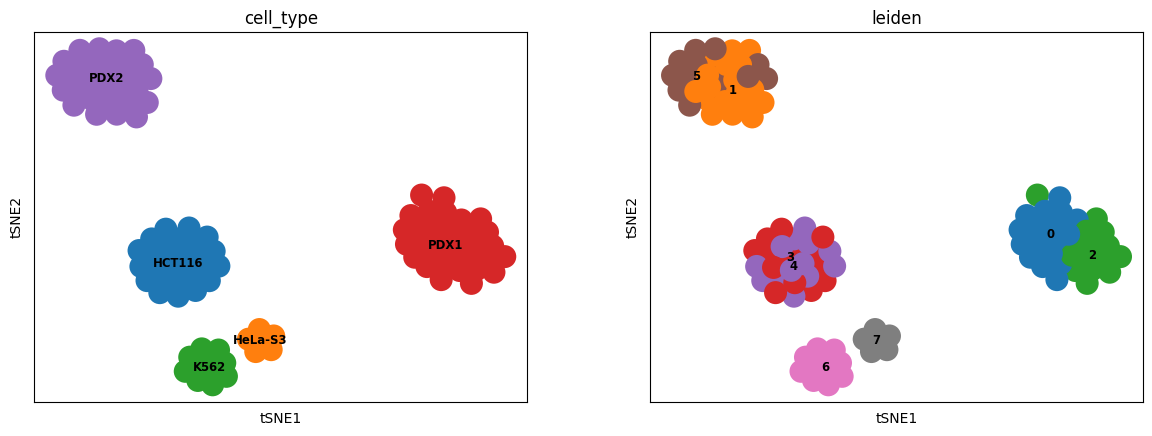

In [17]:
sc.tl.tsne(A2R_predict)
sc.tl.leiden(A2R_predict)
sc.pl.tsne(A2R_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small')

In [18]:
ARI, AMI, NMI, HOM = calculate_cluster_index(A2R_predict)
print('ATAC to RNA:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

ATAC to RNA:
ARI: 0.616, 	AMI: 0.819, 	NMI: 0.834, 	HOM: 1.000, 	COM: 0.716


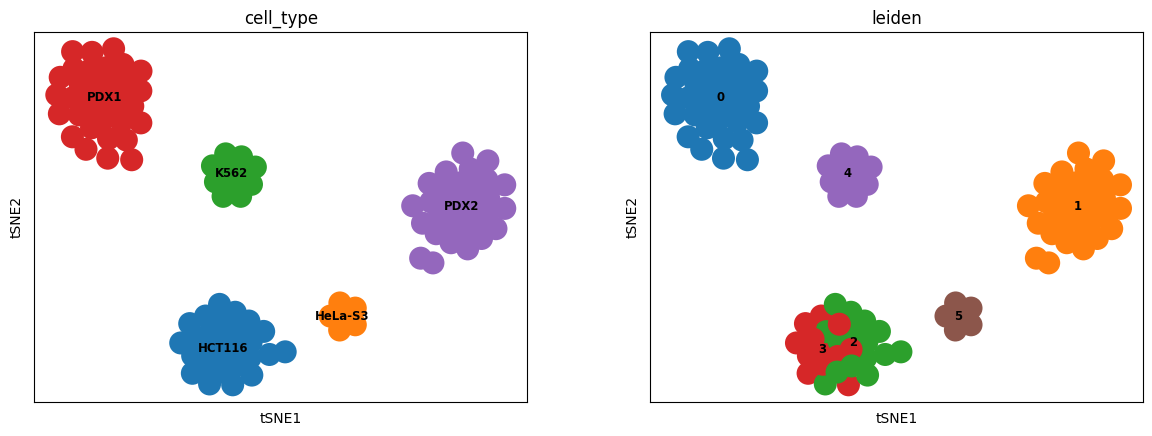

In [19]:
sc.tl.tsne(R2A_predict)
sc.tl.leiden(R2A_predict)
sc.pl.tsne(R2A_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small')

In [20]:
ARI, AMI, NMI, HOM = calculate_cluster_index(R2A_predict)
print('RNA to ATAC:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

RNA to ATAC:
ARI: 0.914, 	AMI: 0.941, 	NMI: 0.945, 	HOM: 1.000, 	COM: 0.895
